In [8]:
# Packages
using CUDA
using Plots, Printf, Statistics
gr()

Plots.GRBackend()

In [2]:
# Functions
@views  d_xa(A) =  A[2:end  , :     ] .- A[1:end-1, :     ];
@views  d_xi(A) =  A[2:end  ,2:end-1] .- A[1:end-1,2:end-1];
@views  d_ya(A) =  A[ :     ,2:end  ] .- A[ :     ,1:end-1];
@views  d_yi(A) =  A[2:end-1,2:end  ] .- A[2:end-1,1:end-1];
@views  d_zi(A) =  A[2:end-1,2:end-1] .- A[2:end-1,2:end-1];
@views av_xa(A) = (A[1:end-1, :     ] .+ A[2:end,   :     ]).*0.5
@views av_ya(A) = (A[ :,     1:end-1] .+ A[ :,     2:end  ]).*0.5
@views   inn(A) =  A[2:end-1,2:end-1]

@views function compute_flux!(qHx, qHy, H, B, g_mu, dx, dy)
    qHx .= g_mu/3.0 .* av_xa(H).^3 .* d_xa(H.+B)./dx
    qHy .= g_mu/3.0 .* av_ya(H).^3 .* d_ya(H.+B)./dy
    return
end

macro dτ() esc(:( 1.0./(1.0/dt .+ 1.0./(min(dx^2,dy^2)/g_mu.*3.0./(inn(H).^3)./4.1)) )) end
@views function update_H!(dHdτ, H, H_t, qHx, qHy, g_mu, dx, dy, dt, damp)
    dHdτ               .= -(inn(H).-inn(H_t))./dt .+ (d_xi(qHx)./dx .+ d_yi(qHy)./dy) .+ damp.*dHdτ
    H[2:end-1,2:end-1] .= inn(H) .+ @dτ().*dHdτ
    return
end

update_H! (generic function with 1 method)

In [3]:
# Physics
g_mu     = 1.0
lx, ly   = 2.0, 2.0;

In [4]:
# Numerics
nx, ny   = 256, 256
nt       = 10
itermax  = 1e4
ncheck   = 10
tolnl    = 1e-8
damp     = 0.8
dx       = lx/(nx-1)
dy       = ly/(ny-1);

In [9]:
# Array initializations
B       = CUDA.zeros(nx  ,ny  )
H       = CUDA.zeros(nx  ,ny  )
H_t     = CUDA.zeros(nx  ,ny  )
H_τ     = CUDA.zeros(nx  ,ny  )
dHdτ    = CUDA.zeros(nx-2,ny-2)
qHx     = CUDA.zeros(nx-1,ny  )
qHy     = CUDA.zeros(nx  ,ny-1);

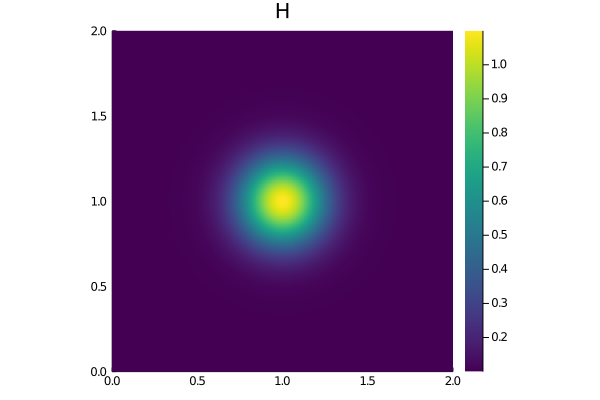

In [11]:
# Initial conditions
B      .= CuArray([0.1 + 0.1*exp(-(((ix-1)*dx-lx/2)*3)^2-(((iy-1)*dy-ly/2)*3)^2) for ix=1:size(B,1), iy=1:size(B,2)])
H      .= CuArray([0.1 + 1.0*exp(-(((ix-1)*dx-lx/2)*4)^2-(((iy-1)*dy-ly/2)*4)^2) for ix=1:size(H,1), iy=1:size(H,2)])

display(heatmap(0:dx:lx, 0:dy:ly, transpose(Array(H)); aspect_ratio=1, xlims=(0, lx), ylims=(0, ly), c=:viridis, title="H"))

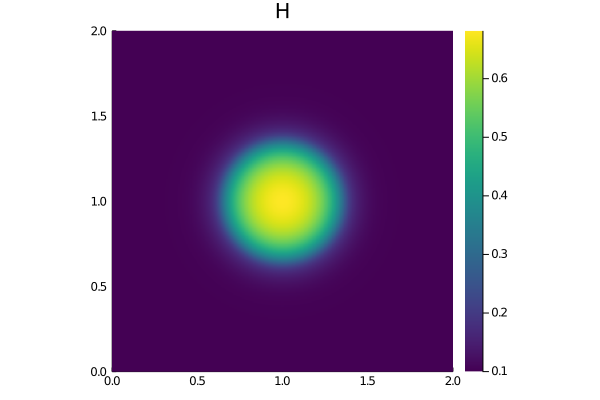

   iter = 10, err = 5.115e-05 
   iter = 20, err = 1.885e-05 
   iter = 30, err = 5.322e-06 
   iter = 40, err = 1.245e-06 
   iter = 50, err = 2.293e-07 
   iter = 60, err = 2.558e-08 
   iter = 70, err = 2.288e-08 
   iter = 80, err = 1.520e-08 
   iter = 90, err = 9.155e-09 


In [12]:
# Time loop
dt = 400*min(dx^2,dy^2)/g_mu*3.0/maximum(H)^3/4.1 # factor*CFL
t  = 0.0
for it = 1:nt
    @printf("it = %d, max H = %1.3e \n", it, maximum(H))
    IJulia.clear_output(true) #Passing true says to wait until new ouput before clearing, this prevents flickering
    display(heatmap(0:dx:lx, 0:dy:ly, transpose(Array(H)); aspect_ratio=1, xlims=(0, lx), ylims=(0, ly), c=:viridis, title="H"))  #Simpler: heatmap!(transpose(Array(H)); aspect_ratio=1, c=:viridis, title="H"); frame(anim)
    H_t .= H
    err=2.0*tolnl; iter=1
    while err > tolnl && iter <= itermax
        if (iter % ncheck == 0) H_τ .= H; end
        compute_flux!(qHx, qHy, H, B, g_mu, dx, dy)
        update_H!(dHdτ, H, H_t, qHx, qHy, g_mu, dx, dy, dt, damp)
        if iter % ncheck == 0
            err = mean(abs.((H.-H_τ)))
            @printf("   iter = %d, err = %1.3e \n", iter, err)
        end
        iter+=1
    end
    t = t + dt
end